# Find best run by iterating through all runs/iterations/crops and calculating f1 scores

In [2]:
import json
import yaml
import numpy as np


def update_combined_dict(combined_dict, output_directory, validation_or_test, roi_name):
    output_directory = output_directory.replace(
        "validation_or_test", validation_or_test
    ).replace("roi_name", str(roi_name))
    with open(f"{output_directory}/scores.json") as f:
        roi_dict = json.load(f)
        for k in ["tp_gt_test_id_pairs", "fp_test_ids", "fn_gt_ids"]:
            del roi_dict["f1_score_info"][k]
        combined_dict[roi_name] = roi_dict
    for key in ["fp", "tp", "fn"]:
        combined_dict["combined"][key] += combined_dict[roi_name]["f1_score_info"][key]
    combined_dict["combined"]["average_f1_score"].append(
        combined_dict[roi_name]["f1_score_info"]["f1_score"]
    )


yaml_name = "jrc_22ak351-leaf-3m_2023-12-06"
with open(
    f"/groups/cellmap/cellmap/ackermand/Programming/plasmodesmata_dacapo/validation_and_test/yamls/combined_yamls/{yaml_name}.yml",
    "r",
) as stream:
    yml = yaml.safe_load(stream)

dataset = yml["dataset"]
gt_array_filename = yml["gt_array"]["filename"]
gt_array_ds_name = yml["gt_array"]["ds_name"]
mask_array_filename = yml["mask_array"]["filename"]
mask_array_ds_name = yml["mask_array"]["ds_name"]

iterations_start, iterations_end, iterations_step = yml["iterations"]
previous_best_f1_score = -1
count = 0
for run in yml["runs"]:
    for iteration in range(iterations_start, iterations_end + 1, iterations_step):
        for postprocessing_suffix in yml["postprocessing_suffixes"]:
            test_array = yml["test_array"]
            combined_validation_dict = {
                "combined": {
                    "tp": 0,
                    "fp": 0,
                    "fn": 0,
                    "f1_score": 0,
                    "average_f1_score": [],
                }
            }
            combined_test_dict = {
                "combined": {
                    "tp": 0,
                    "fp": 0,
                    "fn": 0,
                    "f1_score": 0,
                    "average_f1_score": [],
                }
            }
            for roi in yml["rois"]:
                roi_name = roi["name"]
                output_directory = f"/nrs/cellmap/ackermand/validation_and_testing_scores/{yaml_name}/validation_or_test/{run}/roi_name/iteration_{iteration}{postprocessing_suffix}"
                update_combined_dict(
                    combined_validation_dict,
                    output_directory,
                    "validation",
                    roi_name,
                )
                count += 1
                if roi["split_dimension"] is not None:
                    update_combined_dict(
                        combined_test_dict, output_directory, "test", roi_name
                    )
                    count += 1

            combined_validation_dict["combined"]["f1_score"] = combined_validation_dict[
                "combined"
            ]["tp"] / (
                combined_validation_dict["combined"]["tp"]
                + 0.5
                * (
                    combined_validation_dict["combined"]["fp"]
                    + combined_validation_dict["combined"]["fn"]
                )
            )

            combined_test_dict["combined"]["f1_score"] = combined_test_dict["combined"][
                "tp"
            ] / (
                combined_test_dict["combined"]["tp"]
                + 0.5
                * (
                    combined_test_dict["combined"]["fp"]
                    + combined_test_dict["combined"]["fn"]
                )
            )

            combined_validation_dict["combined"]["average_f1_score"] = np.mean(
                combined_validation_dict["combined"]["average_f1_score"]
            )
            combined_test_dict["combined"]["average_f1_score"] = np.mean(
                combined_test_dict["combined"]["average_f1_score"]
            )

            if (
                combined_validation_dict["combined"]["f1_score"]
                >= previous_best_f1_score
            ):
                previous_best_f1_score = combined_validation_dict["combined"][
                    "f1_score"
                ]
                best_combined_validation_dict = combined_validation_dict
                best_combined_test_dict = combined_test_dict
                if (
                    run
                    == "finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__1"
                ):
                    # NOTE: of all the ones including "more annotations", the above did best at iteration 140000
                    best_combined_validation_dict_select_run = combined_validation_dict
                    best_combined_test_dict_select_run = combined_test_dict
                    print(iteration)
                print(
                    combined_validation_dict["combined"],
                    combined_test_dict["combined"],
                    run,
                    iteration,
                )

{'tp': 543, 'fp': 506, 'fn': 658, 'f1_score': 0.4826666666666667, 'average_f1_score': 0.5356503585471971} {'tp': 705, 'fp': 449, 'fn': 451, 'f1_score': 0.6103896103896104, 'average_f1_score': 0.5827579943762884} finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__0 100000
{'tp': 722, 'fp': 1063, 'fn': 479, 'f1_score': 0.4835900870730074, 'average_f1_score': 0.527193412015262} {'tp': 777, 'fp': 952, 'fn': 379, 'f1_score': 0.5386481802426343, 'average_f1_score': 0.535797834165656} finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__0 140000
{'tp': 677, 'fp': 900, 'fn': 524, 'f1_score': 0.48740100791936647, 'average_f1_score': 0.5277175531523643} {'tp': 770, 'fp': 766, 'fn': 386, 'f1_score': 0.5720653789004457, 'average_f1_score': 0.5435632301681438} finetuned_3d_lsdaffs

In [ ]:
{'tp': 543, 'fp': 506, 'fn': 658, 'f1_score': 0.4826666666666667, 'average_f1_score': 0.5356503585471971} {'tp': 705, 'fp': 449, 'fn': 451, 'f1_score': 0.6103896103896104, 'average_f1_score': 0.5827579943762884} finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__0 100000
{'tp': 722, 'fp': 1063, 'fn': 479, 'f1_score': 0.4835900870730074, 'average_f1_score': 0.527193412015262} {'tp': 777, 'fp': 952, 'fn': 379, 'f1_score': 0.5386481802426343, 'average_f1_score': 0.535797834165656} finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__0 140000
{'tp': 677, 'fp': 900, 'fn': 524, 'f1_score': 0.48740100791936647, 'average_f1_score': 0.5277175531523643} {'tp': 770, 'fp': 766, 'fn': 386, 'f1_score': 0.5720653789004457, 'average_f1_score': 0.5435632301681438} finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__0 160000
{'tp': 707, 'fp': 846, 'fn': 494, 'f1_score': 0.5134350036310821, 'average_f1_score': 0.5530797529757663} {'tp': 737, 'fp': 602, 'fn': 419, 'f1_score': 0.5907815631262525, 'average_f1_score': 0.5599071766719201} finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__0 175000
140000
{'tp': 656, 'fp': 671, 'fn': 545, 'f1_score': 0.5189873417721519, 'average_f1_score': 0.5725561282346001} {'tp': 704, 'fp': 569, 'fn': 452, 'f1_score': 0.5796624125154385, 'average_f1_score': 0.5557892797015216} finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__1 140000
{'tp': 599, 'fp': 489, 'fn': 602, 'f1_score': 0.5233726518130188, 'average_f1_score': 0.5647008435204975} {'tp': 687, 'fp': 403, 'fn': 469, 'f1_score': 0.6117542297417632, 'average_f1_score': 0.6088540953541071} finetuned_3d_lsdaffs_weight_ratio_1.00_plasmodesmata_pseudorandom_training_centers_maxshift_18_unet_default_v2_no_dataset_predictor_node_lr_5E-5__0 135000
{'tp': 641, 'fp': 600, 'fn': 560, 'f1_score': 0.5249795249795249, 'average_f1_score': 0.564424169513621} {'tp': 674, 'fp': 578, 'fn': 482, 'f1_score': 0.5598006644518272, 'average_f1_score': 0.5418744753914604} finetuned_3d_lsdaffs_weight_ratio_1.00_plasmodesmata_pseudorandom_training_centers_maxshift_18_unet_default_v2_no_dataset_predictor_node_lr_5E-5__1 145000

In [12]:
tp = 656 + 704
fp = 671 + 569
fn = 545 + 452
print(tp, fp, fn, tp / (tp + 0.5 * (fp + fn)))


tp = 641 + 674
fp = 600 + 578
fn = 560 + 482
print(tp, fp, fn, tp / (tp + 0.5 * (fp + fn)))

1360 1240 997 0.5487189832560017
1315 1178 1042 0.5422680412371134


In [4]:
# corrected by Xin by checking false positives etc for crops 10
mpd = 60 + 67
pd_in = 57 + 4
tp = 69 + mpd
not_sures = 21 + 6
fp = 245 - (mpd + pd_in + not_sures)
fn = 162
print(tp / (tp + 0.5 * (fp + fn)))

0.6712328767123288


In [4]:
best_combined_validation_dict_select_run


{'combined': {'tp': 656,
  'fp': 671,
  'fn': 545,
  'f1_score': 0.5189873417721519,
  'average_f1_score': 0.5725561282346001},
 'original_small_validation_box': {'f1_score_info': {'tp': 37,
   'fp': 0,
   'fn': 3,
   'f1_score': 0.961038961038961,
   'iou': 0.3627859077722111},
  'iou_score_info': {'iou_score': 0.3627859077722111}},
 2: {'f1_score_info': {'tp': 94,
   'fp': 67,
   'fn': 64,
   'f1_score': 0.5893416927899686,
   'iou': 0.29901182318670955},
  'iou_score_info': {'iou_score': 0.29901182318670955}},
 3: {'f1_score_info': {'tp': 168,
   'fp': 163,
   'fn': 96,
   'f1_score': 0.5647058823529412,
   'iou': 0.25305987059939783},
  'iou_score_info': {'iou_score': 0.25305987059939783}},
 6: {'f1_score_info': {'tp': 45,
   'fp': 103,
   'fn': 70,
   'f1_score': 0.34220532319391633,
   'iou': 0.21708134800275453},
  'iou_score_info': {'iou_score': 0.21708134800275453}},
 7: {'f1_score_info': {'tp': 40,
   'fp': 22,
   'fn': 5,
   'f1_score': 0.7476635514018691,
   'iou': 0.216864

In [16]:
import pandas as pd

key_list = ["tp", "fp", "fn"]
combined_roi_scores = {}
for combined_dict in [
    best_combined_validation_dict_select_run,
    best_combined_test_dict_select_run,
]:
    for roi_name, roi_info in combined_dict.items():
        if roi_name != "combined":
            f1_score_info = roi_info["f1_score_info"]
            if roi_name not in combined_roi_scores:
                combined_roi_scores[roi_name] = {k: 0 for k in key_list}
            for k in key_list:
                combined_roi_scores[roi_name][k] += f1_score_info[k]
            # combined_roi_scores[roi_name]["region"] = roi_name

for roi_name, roi_info in combined_roi_scores.items():
    tp = roi_info["tp"]
    fp = roi_info["fp"]
    fn = roi_info["fn"]
    roi_info["f1_score"] = tp / (tp + 0.5 * (fp + fn))
    roi_info["precision"] = tp / (tp + fp)
    roi_info["recall"] = tp / (tp + fn)
    roi_info["accuracy"] = tp / (tp + fp + fn)


df = pd.DataFrame.from_dict(combined_roi_scores, orient="index")
df.index.name = "region"
df.sort_values("f1_score")

,tp,fp,fn,f1_score,precision,recall,accuracy
region,,,,,,,
10,69,245,162,0.253211,0.219745,0.298701,0.144958
6,89,140,140,0.388646,0.388646,0.388646,0.241192
11,208,233,231,0.472727,0.471655,0.473804,0.309524
2,180,99,137,0.604027,0.645161,0.567823,0.432692
3,374,302,152,0.622296,0.553254,0.711027,0.451691
8,117,77,52,0.644628,0.603093,0.692308,0.475610
7,72,60,19,0.645740,0.545455,0.791209,0.476821
9,214,84,101,0.698206,0.718121,0.679365,0.536341
original_small_validation_box,37,0,3,0.961039,1.000000,0.925000,0.925000


# For annotators, we want to create datasets of tp gt, tp pred, fn gt, fp pred

In [56]:
from funlib.persistence import open_ds, prepare_ds
from funlib.segment.arrays import replace_values
import yaml
import json
import numpy as np

DEF_RUN = False


def get_ids_as_dict(yaml_name, roi_type, run, roi_name, iteration):
    output_dict = {"tp_gt": [], "tp_pred": [], "fn_gt": [], "fp_pred": []}
    scores_filename = f"/nrs/cellmap/ackermand/validation_and_testing_scores/{yaml_name}/{roi_type}/{run}/{roi_name}/iteration_{iteration}_filter_val_0.5_lrb_ratio_-0.08_adj_0.5_lr_-1.2_segs/scores.json"
    with open(scores_filename, "r") as f:
        scores = json.load(f)
    f1_score_info = scores["f1_score_info"]
    for tp_gt_id, tp_pred_id in f1_score_info["tp_gt_test_id_pairs"]:
        output_dict["tp_gt"].append(tp_gt_id)
        output_dict["tp_pred"].append(tp_pred_id)
    output_dict["fn_gt"] = f1_score_info["fn_gt_ids"]
    output_dict["fp_pred"] = f1_score_info["fp_test_ids"]
    return output_dict


if DEF_RUN:
    dataset = "jrc_22ak351-leaf-3m"
    run = "finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__1"
    iteration = "140000"
    yaml_name = f"{dataset}_2023-12-06"

    with open(
        f"/groups/cellmap/cellmap/ackermand/Programming/plasmodesmata_dacapo/validation_and_test/yamls/combined_yamls/{yaml_name}.yml",
        "r",
    ) as stream:
        yml = yaml.safe_load(stream)

    gt_ds = open_ds(
        filename=f"/nrs/cellmap/ackermand/cellmap/leaf-gall/{dataset}.n5",
        ds_name="plasmodesmata_as_cylinders",
    )

    running_id_count_dict = {"tp_gt": 0, "tp_pred": 0, "fn_gt": 0, "fp_pred": 0}
    for ds_name in running_id_count_dict.keys():
        prepare_ds(
            filename=f"/nrs/cellmap/ackermand/forAnnotators/leaf-gall/{yaml_name}.n5",
            ds_name=ds_name,
            dtype=gt_ds.dtype,
            write_size=gt_ds.chunk_shape * gt_ds.voxel_size,
            total_roi=gt_ds.roi,
            voxel_size=gt_ds.voxel_size,
            delete=True,
        )

    for roi in yml["rois"]:
        roi_types = ["validation"]
        roi_name = roi["name"]
        if roi["split_dimension"] is not None:
            roi_types.append("test")

        for roi_type in roi_types:
            print((roi_name, roi_type))
            pred_ds = open_ds(
                filename=f"/nrs/cellmap/ackermand/predictions/{dataset}/{dataset}.n5/processed/{roi_type}/{run}/{roi_name}.n5",
                ds_name=f"iteration_{iteration}_filter_val_0.5_lrb_ratio_-0.08_adj_0.5_lr_-1.2_segs",
            )
            pred_data = pred_ds.to_ndarray()
            gt_data = gt_ds.to_ndarray(pred_ds.roi)

            output_ds_to_ids_dict = get_ids_as_dict(
                yaml_name, roi_type, run, roi_name, iteration
            )

            for output_ds_name, ids in output_ds_to_ids_dict.items():
                if "pred" in output_ds_name:
                    data = pred_data
                else:
                    data = gt_data

                num_ids = len(ids)
                if num_ids > 0:
                    relabeled_ids = list(
                        range(
                            running_id_count_dict[output_ds_name] + 1,
                            running_id_count_dict[output_ds_name] + num_ids + 1,
                        )
                    )
                    output_data = np.zeros_like(data, dtype=gt_ds.dtype)
                    replace_values(data, ids, relabeled_ids, output_data)

                    output_ds = open_ds(
                        f"/nrs/cellmap/ackermand/forAnnotators/leaf-gall/{yaml_name}.n5",
                        output_ds_name,
                        mode="r+",
                    )
                    output_ds[pred_ds.roi] = output_data
                    running_id_count_dict[output_ds_name] += num_ids

    # relabelled: np.ndarray = np.zeros_like(fragments)

    # read in roi and write out values to corresponding datasets
    # need to relabel test/validation ids to keep them unique

('original_small_validation_box', 'validation')
(2, 'validation')
(2, 'test')
(3, 'validation')
(3, 'test')
(6, 'validation')
(6, 'test')
(7, 'validation')
(7, 'test')
(8, 'validation')
(8, 'test')
(9, 'validation')
(9, 'test')
(10, 'validation')
(10, 'test')
(11, 'validation')
(11, 'test')


In [51]:
from funlib.persistence import open_ds, prepare_ds
from funlib.segment.arrays import replace_values
import yaml
import json
import numpy as np


def get_ids_as_dict(yaml_name, roi_type, run, roi_name, iteration):
    output_dict = {"tp_gt": [], "tp_pred": [], "fn_gt": [], "fp_pred": []}
    scores_filename = f"/nrs/cellmap/ackermand/validation_and_testing_scores/{yaml_name}/{roi_type}/{run}/{roi_name}/iteration_{iteration}_filter_val_0.5_lrb_ratio_-0.08_adj_0.5_lr_-1.2_segs/scores.json"
    with open(scores_filename, "r") as f:
        scores = json.load(f)
    f1_score_info = scores["f1_score_info"]
    for tp_gt_id, tp_pred_id in f1_score_info["tp_gt_test_id_pairs"]:
        output_dict["tp_gt"].append(tp_gt_id)
        output_dict["tp_pred"].append(tp_pred_id)
    output_dict["fn_gt"] = f1_score_info["fn_gt_ids"]
    output_dict["fp_pred"] = f1_score_info["fp_test_ids"]
    return output_dict


dataset = "jrc_22ak351-leaf-3m"
run = "finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__1"
iteration = "140000"
yaml_name = f"{dataset}_2023-12-06"

with open(
    f"/groups/cellmap/cellmap/ackermand/Programming/plasmodesmata_dacapo/validation_and_test/yamls/combined_yamls/{yaml_name}.yml",
    "r",
) as stream:
    yml = yaml.safe_load(stream)

running_id_count_dict = {"tp_gt": 0, "tp_pred": 0, "fn_gt": 0, "fp_pred": 0}

for roi in yml["rois"]:
    roi_types = ["validation"]
    roi_name = roi["name"]
    if roi["split_dimension"] is not None:
        roi_types.append("test")

    for roi_type in roi_types:
        output_ds_to_ids_dict = get_ids_as_dict(
            yaml_name, roi_type, run, roi_name, iteration
        )
        for output_ds_name, ids in output_ds_to_ids_dict.items():
            num_ids = len(ids)
            if num_ids > 0:
                relabeled_ids = list(
                    range(
                        running_id_count_dict[output_ds_name] + 1,
                        running_id_count_dict[output_ds_name] + num_ids + 1,
                    )
                )
                running_id_count_dict[output_ds_name] += num_ids

# Fit line segments to each 

## Write out lines as annotations

In [3]:
import numpy as np
from neuroglancer.write_annotations import AnnotationWriter
from neuroglancer import AnnotationPropertySpec
from neuroglancer.coordinate_space import CoordinateSpace
import numpy as np
import numpy as np
from funlib.geometry import Roi
from funlib.persistence import open_ds
import pandas as pd
from tqdm import tqdm


def find_line_cube_intersection(cube_min, cube_max, line_origin, line_direction):
    # chatgpt
    t_values = []

    # Check intersection with each face of the cube
    for i in range(3):
        if line_direction[i] != 0:
            t1 = (cube_min[i] - line_origin[i]) / line_direction[i]
            t2 = (cube_max[i] - line_origin[i]) / line_direction[i]
            t_values.extend([t1, t2])

    # Find the valid t values (inside the cube)
    valid_t_values = [
        t
        for t in t_values
        if all(
            cube_min[j] <= line_origin[j] + t * line_direction[j] <= cube_max[j]
            for j in range(3)
        )
    ]

    # Find the intersection points
    intersection_points = [line_origin + t * line_direction for t in valid_t_values]

    # Calculate the minimum and maximum values along each axis
    min_point = np.min(intersection_points, axis=0)
    max_point = np.max(intersection_points, axis=0)

    # Return the two endpoints of the line segment within the cube
    return min_point, max_point


def find_min_max_projected_points(points, line_point, line_direction):
    # chatgpt
    line_direction = line_direction / np.linalg.norm(
        line_direction
    )  # Normalize direction vector

    # Calculate the vector from line_point to each point
    point_vectors = points - line_point

    # Calculate the projection scalar for each point using dot product and broadcasting
    projection_scalars = np.sum(point_vectors * line_direction, axis=1)

    # Calculate the projected points for each point
    projected_points = line_point + projection_scalars[:, np.newaxis] * line_direction

    # Find the minimum and maximum projection scalar indices
    min_projection_idx = np.argmin(projection_scalars)
    max_projection_idx = np.argmax(projection_scalars)

    return projected_points[min_projection_idx], projected_points[max_projection_idx]


dataset = "jrc_22ak351-leaf-3m"
run = "finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__1"
iteration = "140000"
yaml_name = f"{dataset}_2023-12-06"

# since it is arbitrary to have endpoints for line segment in terms of fitting, will just fit a line and then truncate it
for ds_name in ["tp_gt", "tp_pred", "fn_gt", "fp_pred"]:
    print(ds_name)
    annotation_writer = AnnotationWriter(
        CoordinateSpace(names=("x", "y", "z"), scales=(1, 1, 1), units="nm"),
        annotation_type="line",
        properties=[
            AnnotationPropertySpec(id="identifier", type="uint16"),
        ],
    )
    df = pd.read_csv(
        f"/nrs/cellmap/ackermand/forAnnotators/leaf-gall/analysisResults/{yaml_name}/{ds_name}.csv"
    )
    ds = open_ds(
        f"/nrs/cellmap/ackermand/forAnnotators/leaf-gall/{yaml_name}.n5", ds_name
    )
    # uu, dd, vv = np.linalg.svd(data - datamean, full_matrices=False)
    for _, row in tqdm(df.iterrows(), total=len(df)):
        cube_min = np.array([row[f"MIN {d} (nm)"] for d in ["Z", "Y", "X"]])
        cube_max = np.array([row[f"MAX {d} (nm)"] for d in ["Z", "Y", "X"]])
        com = np.array([row[f"COM {d} (nm)"] for d in ["Z", "Y", "X"]])

        roi = Roi(cube_min - 8, (cube_max - cube_min) + 16)

        id = row["Object ID"]
        data = np.column_stack(np.where(ds.to_ndarray(roi) == id))
        uu, dd, vv = np.linalg.svd(data - np.mean(data, axis=0), full_matrices=False)

        line_direction = vv[0]
        line_origin = com

        # start_point, end_point = find_line_cube_intersection(
        #     cube_min, cube_max, line_origin, line_direction
        # )
        start_point, end_point = find_min_max_projected_points(
            data * 8 + 4 + roi.begin, line_origin, line_direction
        )
        annotation_writer.add_line(
            point_a=start_point[::-1],
            point_b=end_point[::-1],
            id=int(id),
            identifier=int(id),
        )

    annotation_writer.write(
        f"/groups/cellmap/cellmap/ackermand/neuroglancer_annotations/leaf-gall/forAnnotators/{yaml_name}/{ds_name}"
    )

tp_gt


100%|██████████| 1360/1360 [01:22<00:00, 16.55it/s]


tp_pred


100%|██████████| 1360/1360 [01:24<00:00, 16.06it/s]


fn_gt


100%|██████████| 997/997 [01:01<00:00, 16.32it/s]


fp_pred


100%|██████████| 1240/1240 [01:03<00:00, 19.49it/s]


## Write out annotation boxes

In [48]:
import numpy as np
from neuroglancer.write_annotations import AnnotationWriter
from neuroglancer.coordinate_space import CoordinateSpace
from neuroglancer import AnnotationPropertySpec
import numpy as np
import numpy as np
import yaml
from funlib.persistence import open_ds


dataset = "jrc_22ak351-leaf-3m"
run = "finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__1"
iteration = "140000"
yaml_name = f"{dataset}_2023-12-06"
with open(
    f"/groups/cellmap/cellmap/ackermand/Programming/plasmodesmata_dacapo/validation_and_test/yamls/combined_yamls/{yaml_name}.yml",
    "r",
) as stream:
    yml = yaml.safe_load(stream)

annotation_writer = AnnotationWriter(
    CoordinateSpace(names=("x", "y", "z"), scales=(1, 1, 1), units="nm"),
    annotation_type="axis_aligned_bounding_box",
    properties=[
        AnnotationPropertySpec(id="identifier", type="uint16"),
        AnnotationPropertySpec(id="box_color", type="rgb"),
    ],
)

# since it is arbitrary to have endpoints for line segment in terms of fitting, will just fit a line and then truncate it

roi_name_to_color_dict = {
    "original_small_validation_box": (255, 255, 0),
    2: (6, 254, 255),
    3: (196, 84, 248),
    6: (255, 102, 0),
    7: (0, 255, 17),
    8: (216, 20, 255),
    9: (128, 234, 255),
    10: (255, 234, 0),
    11: (3, 0, 153),
}
for roi in yml["rois"]:
    roi_name = roi["name"]
    identifier = 0 if roi_name == "original_small_validation_box" else roi["name"]
    roi_types = ["validation"]
    if roi["split_dimension"] is not None:
        roi_types.append("test")
    for type_idx, roi_type in enumerate(roi_types):
        ds = open_ds(
            filename=f"/nrs/cellmap/ackermand/predictions/{dataset}/{dataset}.n5/processed/{roi_type}/{run}/{roi_name}.n5",
            ds_name=f"iteration_{iteration}_filter_val_0.5_lrb_ratio_-0.08_adj_0.5_lr_-1.2_segs",
        )
        roi = ds.roi
        annotation_writer.add_axis_aligned_bounding_box(
            point_a=roi.begin[::-1],
            point_b=roi.end[::-1],
            identifier=identifier * 100 + type_idx,
            box_color=roi_name_to_color_dict[roi_name],
        )

        annotation_writer.write(
            f"/groups/cellmap/cellmap/ackermand/neuroglancer_annotations/leaf-gall/forAnnotators/{yaml_name}/bounding_boxes"
        )

## Composite images

In [1]:
import dask.diagnostics
import dask.array as da
from dask.distributed import Client
import numpy as np
from scipy.ndimage import binary_erosion
from funlib.persistence import open_ds
from funlib.geometry import Roi
import itertools
import numpy as np
from funlib.geometry import Roi
import scipy
from funlib.persistence import open_ds
from skimage.metrics import structural_similarity as ssim
from utils.utils import get_rotation_matrix, extract_precomputed_annotations
from funlib.persistence import prepare_ds
from funlib.geometry import Coordinate, Roi


dataset = "jrc_22ak351-leaf-3m"
yaml_name = f"{dataset}_2023-12-06"

ds = open_ds(
    f"/nrs/cellmap/data/{dataset}/{dataset}.n5",
    "/em/fibsem-uint8/s0",
)


pad = 60  # want this to be the cube size, but we need to make sure that all rotated cubes contain voxels in this region even when rotated, so we need this larger cubes
extra_pad = int(np.ceil(np.sqrt(3) * pad))


@dask.delayed
def read_and_align_image(current_pd):
    pd_start = current_pd[:3]
    pd_end = current_pd[3:]
    pd_center = np.round(0.5 * (pd_start + pd_end) / 8) * 8
    # https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d/476311#476311
    v1 = pd_start - pd_end
    # v1 = np.array([1, 0, 0])
    v2 = np.array([0, 0, 1])
    rot = get_rotation_matrix(v1, v2)

    roi = Roi((pd_center - extra_pad * 8)[::-1], [(extra_pad * 2 + 1) * 8] * 3)
    im = ds.to_ndarray(roi).swapaxes(0, 2)
    # Translation matrix to shift the image center to the origin
    x, y, z = im.shape
    trans = np.array((-x / 2, -y / 2, -z / 2))

    T = np.identity(4)
    T[:3, -1] = trans
    im = scipy.ndimage.affine_transform(
        im, np.linalg.inv(np.linalg.inv(T).dot(rot).dot(T)), order=0
    )
    im = im[
        extra_pad - pad : extra_pad + pad + 1,
        extra_pad - pad : extra_pad + pad + 1,
        extra_pad - pad : extra_pad + pad + 1,
    ]
    return da.from_array(im)


for ds_name in ["tp_gt", "tp_pred", "fn_gt", "fp_pred"]:
    with Client(threads_per_worker=1, n_workers=1) as client:
        client.cluster.scale(10)
        print(client.dashboard_link.replace("127.0.0.1", "ackermand-ws2.hhmi.org"))
        _, pds = extract_precomputed_annotations(
            f"/groups/cellmap/cellmap/ackermand/neuroglancer_annotations/leaf-gall/forAnnotators/{yaml_name}/{ds_name}"
        )
        print(ds_name)
        aligned_images = [
            da.from_delayed(
                read_and_align_image(current_pd),
                (extra_pad * 2 + 1, extra_pad * 2 + 1, extra_pad * 2 + 1),
                np.float64,
            )
            for current_pd in pds
        ]

        # Stack all small Dask arrays into one
        stack = da.stack(aligned_images, axis=0)
        composite_image = stack.mean(axis=0).compute()

        # composite_image = (
        #     255
        #     * (composite_image - composite_image.min())
        #     / (composite_image.max() - composite_image.min())
        # )
        roi = Roi((0, 0, 0), np.array(composite_image.shape) * 8)
        output_ds = prepare_ds(
            f"/nrs/cellmap/ackermand/forAnnotators/leaf-gall/{yaml_name}.n5",
            f"composite_images/{ds_name}",
            total_roi=roi,
            voxel_size=np.array([8, 8, 8]),
            dtype=np.uint8,
            write_size=Coordinate(3 * [8 * 128]),
            # force_exact_write_size=True
        )
        output_ds[roi] = composite_image

http://ackermand-ws2.hhmi.org:8787/status
tp_gt
http://ackermand-ws2.hhmi.org:8787/status
tp_pred
http://ackermand-ws2.hhmi.org:8787/status
fn_gt
http://ackermand-ws2.hhmi.org:8787/status
fp_pred


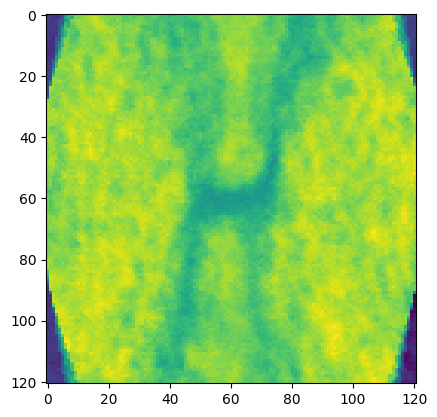

In [6]:
import matplotlib.pyplot as plt

plt.imshow(composite_image[60, :, :])